## Test of deconvolution of the Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal
import torch
from sonar import sonar, utils
from numpy.fft import fft, ifft

In [40]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [41]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


In [91]:
def make_kernel(co_occ_templ, rad_kern = 500): #rad_kern should be same as rad_
    grad = np.diff(co_occ_templ)
    first_neg = np.where(grad[0,0] > 0)
    grad_pos = grad[0,0][:first_neg[0][0]]
    extender = np.zeros(rad_kern-len(grad_pos)*2)
    flipped = -grad_pos
    flipped_tail = flipped[::-1]

    before_conv = np.concatenate([flipped, extender, flipped_tail])
    new_kernel = np.convolve(before_conv, before_conv, mode = "same")

    return new_kernel

In [110]:
def deconvolving(co_occ_templ, lmbd = 0.1, ylim_1=-0.05, ylim_2=0.1):
    lambd = lmbd
    new_kernel = np.roll(make_kernel(co_occ_templ),250)
    signal = co_occ_templ[0,0].copy()
    signal = signal[:]

    H = fft(new_kernel)
    S = fft(signal)
    deconvolved = np.real(ifft(S*np.conj(H)/(H*np.conj(H) + lambd**2))) # <- Wiener deconvolution

    plt.figure(figsize=[15,5])

    plt.plot(signal)
    plt.plot(new_kernel)
    plt.plot(deconvolved/deconvolved.max()*signal.max())

    plt.legend(['signal','kernel','deconvolved'], fontsize="8")
    plt.ylim((ylim_1,ylim_2))
    
    # return deconvolved


In [86]:
plt.figure(figsize=[10,10])

n_sample = 1

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

<Figure size 1000x1000 with 0 Axes>

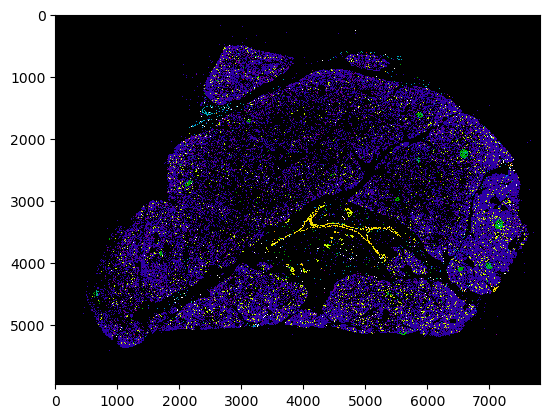

In [6]:
# plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

In [109]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
rescaled_splitted = np.split(rescaled, 16)
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)
cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)

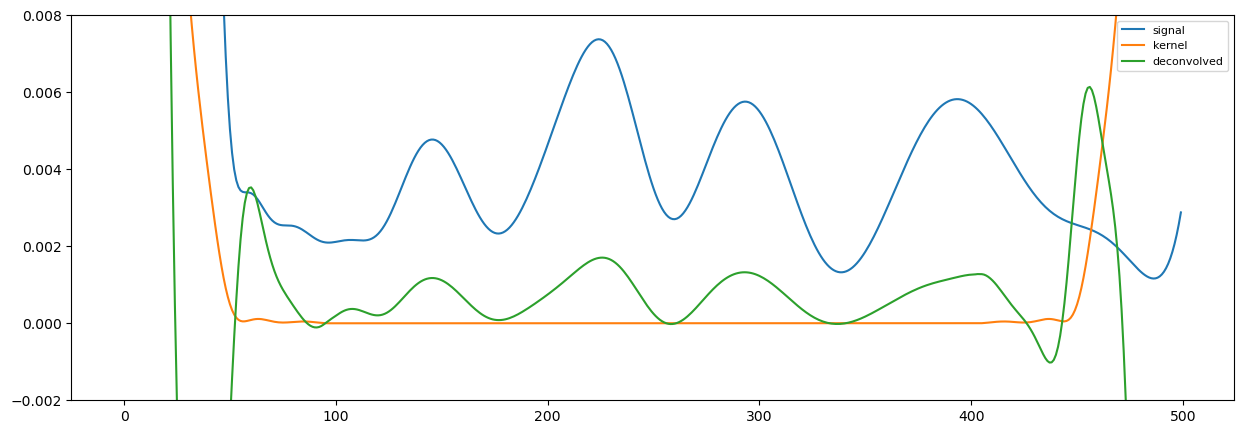

In [95]:
deconvolving(cooc_template_,  ylim_1=-0.002, ylim_2=0.008)

### Sample 3

In [96]:
n_sample = 3

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

In [ ]:
# plt.figure(figsize=[15,8])

# plt.subplot(1,2,1)
# plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

# plt.subplot(1,2,2)
# plt.imshow(tissue_matrix.argmax(axis=0)[1700:2000,1000:2000],cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)[1700:2000,1000:2000]!=0).astype(float))

In [97]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()

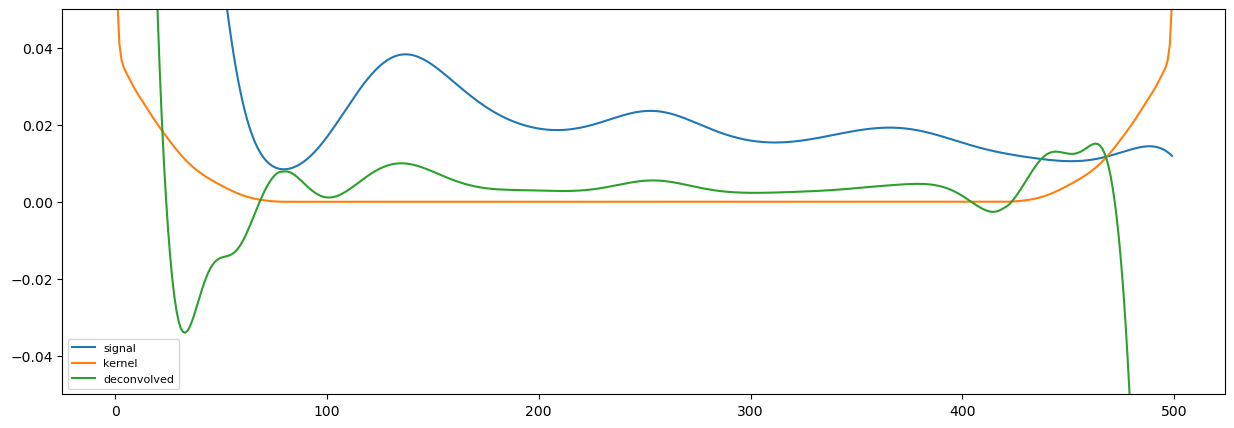

In [102]:
rescaled_splitted = np.split(rescaled, 16)
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)

deconvolving(cooc_template_, ylim_1=-0.05, ylim_2=0.05)

### Sample 2

In [103]:
n_sample = 2

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

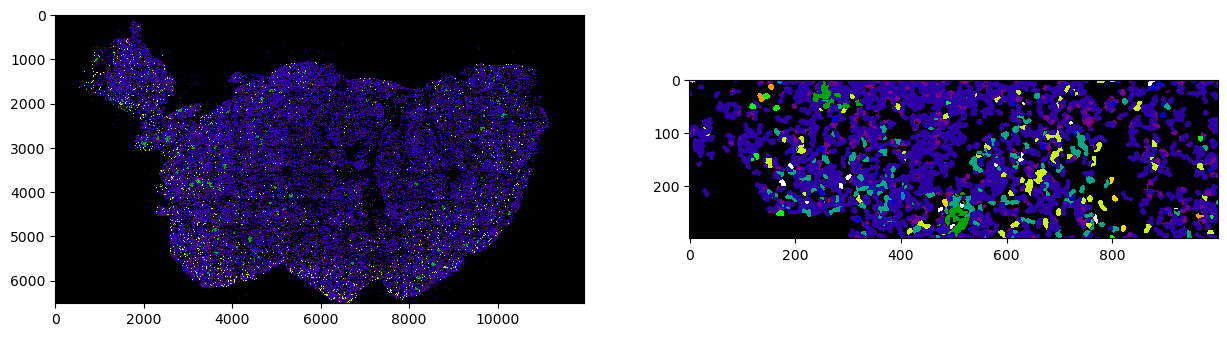

In [78]:
# plt.figure(figsize=[15,8])

# plt.subplot(1,2,1)
# plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

# plt.subplot(1,2,2)
# plt.imshow(tissue_matrix.argmax(axis=0)[1700:2000,1000:2000],cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)[1700:2000,1000:2000]!=0).astype(float))

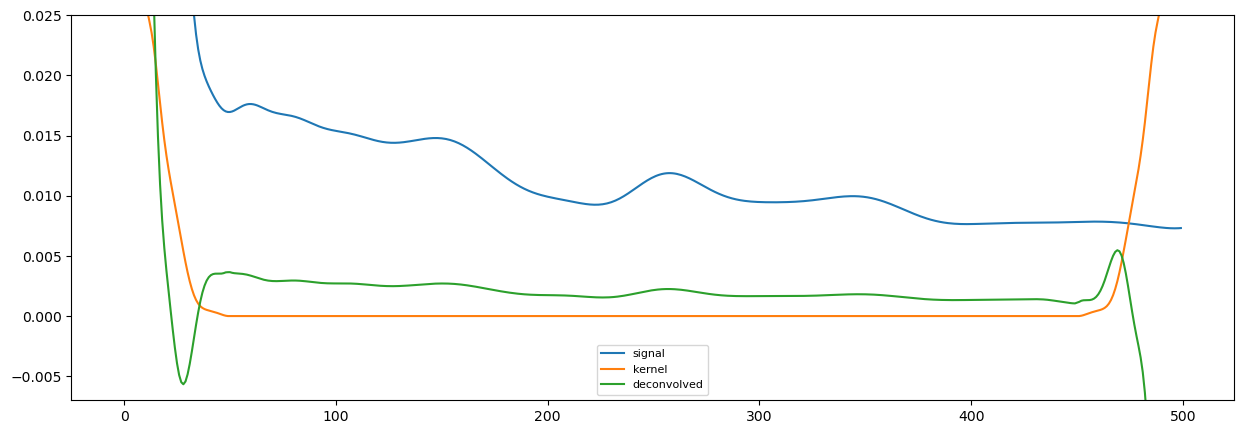

In [105]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
rescaled_splitted = np.split(rescaled, 16)
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)

deconvolving(cooc_template_, ylim_1=-0.007, ylim_2=0.025)


### Sample 4

In [70]:
n_sample = 4

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

In [ ]:
plt.figure(figsize=[15,8])

plt.subplot(1,2,1)
plt.imshow(tissue_matrix.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)!=0).astype(float))

plt.subplot(1,2,2)
plt.imshow(tissue_matrix.argmax(axis=0)[1700:2000,1000:2000],cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(tissue_matrix.sum(0)[1700:2000,1000:2000]!=0).astype(float))

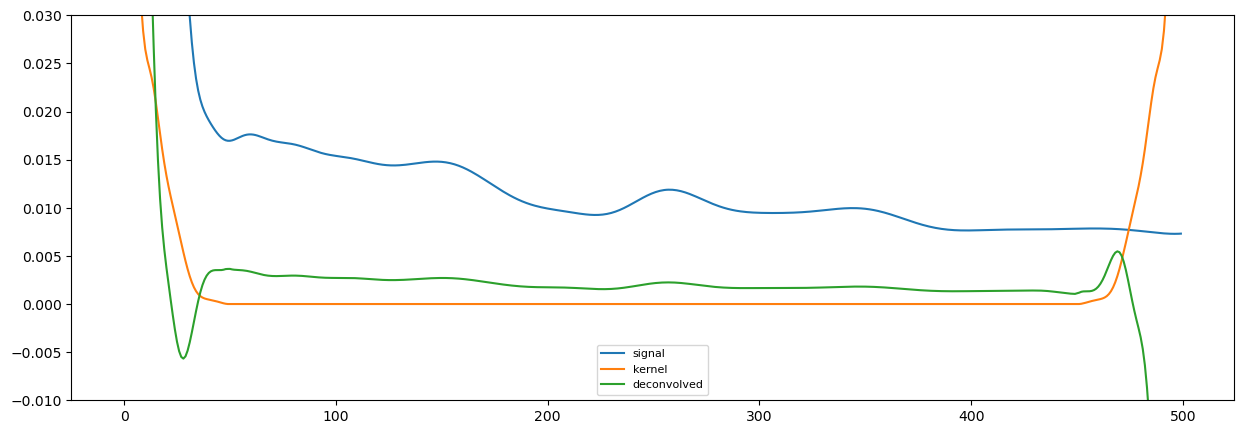

In [108]:
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
rescaled_splitted = np.split(rescaled, 16)
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)

cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)

deconvolving(cooc_template_, ylim_1=-0.01, ylim_2=0.03)

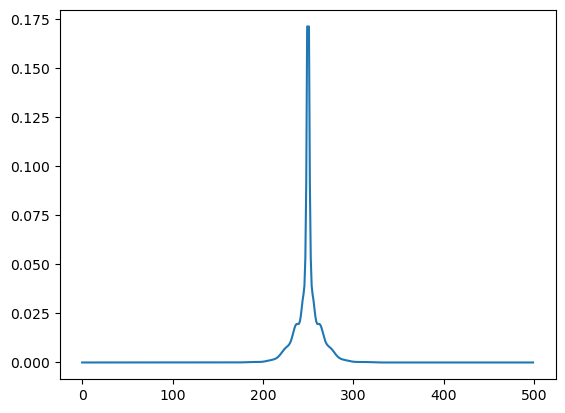

In [136]:
n_sample = 4
# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
rescaled_splitted = np.split(rescaled, 16)
islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)
cooc_template_ = son.co_occurrence_from_tensor(islet_stack,interpolate=True)


grad = np.diff(cooc_template_)
first_neg = np.where(grad[0,0] > 0)
grad_pos = grad[0,0][:first_neg[0][0]]
extender = np.zeros(500-len(grad_pos)*2)
flipped = -grad_pos
flipped_tail = flipped[::-1]

before_conv = np.concatenate([flipped, extender, flipped_tail])
new_kernel = np.convolve(before_conv, before_conv, mode = "same")
new_kernel[[250]] = new_kernel[[251]]

# plt.plot(np.roll(new_kernel,250))
plt.plot(new_kernel)

In [133]:
new_kernel[[249,250,251]]

array([0.17115575, 0.17115575, 0.17115575])

In [132]:
new_kernel[[250]] = new_kernel[[251]]

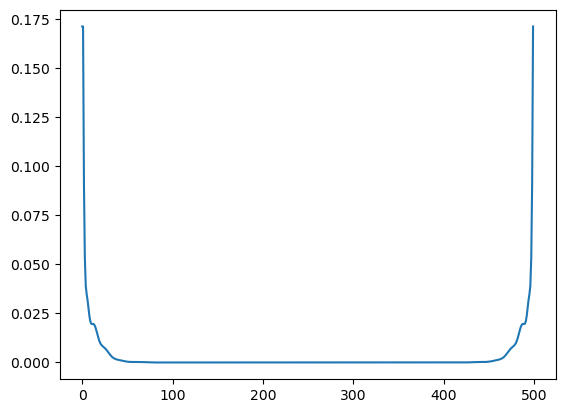

In [134]:
plt.plot(np.roll(new_kernel,250))